In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd

In [2]:
cases = pd.read_csv("data/samoa_cases.csv", header=0, parse_dates=["Date"], dayfirst=True)
raw_times = cases["Date"].to_numpy()
raw_times = [(t-raw_times[0])/np.timedelta64(1,'D') for t in raw_times] # convert to days since first timestamp
raw_data = cases['Cases'].to_numpy()
raw_cumdata = np.cumsum(raw_data)

In [3]:
start = 1
clip = 5
times = raw_times[start:(-clip if clip else None)]
data = raw_data[start:(-clip if clip else None)]
cumdata = raw_cumdata[start:(-clip if clip else None)]

In [4]:
times = [75,83,86,87,89,90,91]
cumdata = [716,1174,1644,1797,2194,2437,2686]

# times = times + additional_times
# cumdata = np.concatenate([cumdata,additional_cumdata])

In [5]:
def rcp(t, y, p):
    return [
        p[0]*y[0]**p[1]
    ]


In [6]:
data_pd = np.array([[i] for i in cumdata])
p0 = [1, 0]
config = {
    "grid_size": 100,
    "basis_number": 24,
    "model_form": {
        "state": 1,
        "parameters": 2
    },
    "time_span": [times[0], times[-1]],
    "knot_function": None,
    "model": rcp,
    "dataset": {"y": data_pd, "t": np.array(times)},
    "observation_vector": [-1],
    "weightings":[
        [1]*1,
        times
    ],
    "regularisation_value": copy(p0),
}

In [7]:
model = modeller.Model(config)
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup)

In [8]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [9]:
c0 = np.ones(config['basis_number'])
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']) + [0]*len(config['regularisation_value'])
alpha = 1e1

In [10]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     2400
Number of nonzeros in Lagrangian Hessian.............:      351

Total number of variables............................:       26
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

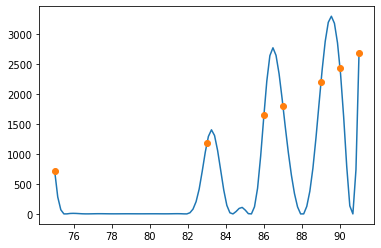

In [11]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs)
plt.plot(times, cumdata, 'o')

In [12]:
prange = np.logspace(-6, 6, num=80)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
    }
    print(f"Attempting Solve for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Attempting Solve for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     2400
Number of nonzeros in Lagrangian Hessian.............:      351

Total number of variables............................:       26
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      100
        inequality constraints with only lower bounds:      100
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg)

  13  2.8399467e-02 0.00e+00 1.48e-09  -8.6 2.83e-04    -  1.00e+00 1.00e+00h  1
  14  2.8399382e-02 0.00e+00 8.71e-10  -8.6 6.71e-05    -  1.00e+00 1.00e+00h  1
  15  2.8399374e-02 0.00e+00 4.88e-10  -8.6 2.42e-05    -  1.00e+00 1.00e+00h  1
  16  2.8399373e-02 0.00e+00 7.30e-10  -9.0 4.70e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:   2.8399373496851964e-02    2.8399373496851964e-02
Dual infeasibility......:   7.3008105409140793e-10    7.3008105409140793e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.3689479771603599e-09    1.3689479771603599e-09
Overall NLP error.......:   1.3689479771603599e-09    1.3689479771603599e-09


Number of objective function evaluations             = 17
Number of objective gradient evaluations             = 17
Number of equality constraint evaluations            = 0
Number of ineq

   2  1.3816426e+00 0.00e+00 4.60e-03  -1.0 1.21e+01    -  9.90e-01 1.00e+00f  1
   3  1.3676669e+00 0.00e+00 5.01e-03  -1.7 7.43e+01    -  1.00e+00 1.00e+00f  1
   4  1.3359877e+00 0.00e+00 1.82e-03  -2.5 6.35e+01    -  1.00e+00 1.00e+00f  1
   5  1.3314877e+00 0.00e+00 5.13e-04  -3.8 1.97e+01    -  1.00e+00 1.00e+00f  1
   6  1.3308148e+00 0.00e+00 1.05e-04  -3.8 3.51e-01    -  1.00e+00 1.00e+00f  1
   7  1.3306884e+00 0.00e+00 2.54e-05  -5.7 9.30e-01    -  1.00e+00 1.00e+00f  1
   8  1.3306785e+00 0.00e+00 2.67e-06  -5.7 9.08e-04    -  1.00e+00 1.00e+00f  1
   9  1.3306783e+00 0.00e+00 6.20e-08  -8.6 1.16e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3306783e+00 0.00e+00 2.52e-10  -8.6 2.94e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.3306783382081691e+00    1.3306783382081691e+00
Dual infeas

Dual infeasibility......:   6.2414245089049274e-10    6.2414245089049274e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5062686807034474e-09    2.5062686807034474e-09
Overall NLP error.......:   2.5062686807034474e-09    2.5062686807034474e-09


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 9
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 9
Number of Lagrangian Hessian evaluations             = 8
Total CPU secs in IPOPT (w/o function evaluations)   =      0.009
Total CPU secs in NLP function evaluations           =      0.004

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 132.00us ( 14.67us) 132.87us ( 14.76us)       

  18  3.3177166e+01 0.00e+00 1.65e+01  -2.5 1.49e+00    -  1.00e+00 1.00e+00f  1
  19  3.3176855e+01 0.00e+00 4.59e-03  -2.5 4.73e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.3176852e+01 0.00e+00 4.96e-03  -3.8 4.23e-02    -  1.00e+00 1.00e+00h  1
  21  3.3176852e+01 0.00e+00 2.52e-09  -3.8 1.33e-06    -  1.00e+00 1.00e+00h  1
  22  3.3176852e+01 0.00e+00 3.19e-05  -5.7 2.29e-03    -  1.00e+00 1.00e+00h  1
  23  3.3176852e+01 0.00e+00 4.52e-10  -5.7 3.18e-09    -  1.00e+00 1.00e+00H  1
  24  3.3176852e+01 0.00e+00 4.91e-09  -8.6 2.84e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 24

                                   (scaled)                 (unscaled)
Objective...............:   3.3176852410262661e+01    3.3176852410262661e+01
Dual infeasibility......:   4.9106966907498553e-09    4.9106966907498553e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

   7  2.4182597e+02 0.00e+00 6.04e-06  -5.7 9.32e-05    -  1.00e+00 1.00e+00h  1
   8  2.4182597e+02 0.00e+00 1.83e-09  -8.6 1.16e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   2.4182597101574757e+02    2.4182597101574757e+02
Dual infeasibility......:   1.8278790709497488e-09    1.8278790709497488e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059554095062765e-09    2.5059554095062765e-09
Overall NLP error.......:   2.5059554095062765e-09    2.5059554095062765e-09


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 9
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 9
Number o


Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   1.2626408066084077e+03    1.2626408066084077e+03
Dual infeasibility......:   3.4444147175845090e-09    3.4444147175845090e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059126884972245e-09    2.5059126884972245e-09
Overall NLP error.......:   3.4444147175845090e-09    3.4444147175845090e-09


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 10
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 10
Number of Lagrangian Hessian evaluations             = 9
Total CPU secs in IPOPT (w/o function evaluations)   =      0.010
Total CPU secs in NLP function evaluations 


Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   1.4286353066556103e+04    1.4286353066556103e+04
Dual infeasibility......:   9.3101077837701366e-08    9.3101077837701366e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090920e-10    9.0909090909090920e-10
Overall NLP error.......:   9.3101077837701366e-08    9.3101077837701366e-08


Number of objective function evaluations             = 14
Number of objective gradient evaluations             = 14
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 14
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 14
Number of Lagrangian Hessian evaluations             = 14
Total CPU secs in IPOPT (w/o function evaluations)   =      0.011
Total CPU secs in NLP function evaluation

  11  4.0535767e+04 0.00e+00 1.41e-07  -9.0 6.04e-12    -  1.00e+00 1.00e+00H  1
  12  4.0535767e+04 0.00e+00 4.33e-07  -9.0 4.62e-13    -  1.00e+00 1.00e+00   0
  13  4.0535767e+04 0.00e+00 1.99e-07  -9.0 1.04e-12    -  1.00e+00 1.00e+00T  0

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   3.5049193009751070e+04    4.0535767450485975e+04
Dual infeasibility......:   1.9923131919097558e-07    2.3041884077993176e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090920e-10    1.0513993195794183e-09
Overall NLP error.......:   1.9923131919097558e-07    2.3041884077993176e-07


Number of objective function evaluations             = 15
Number of objective gradient evaluations             = 14
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 15
Number of equality constraint Jacobia

Total number of variables............................:       26
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      100
        inequality constraints with only lower bounds:      100
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.0390737e+05 0.00e+00 3.56e+07  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  4.3693640e+05 0.00e+00 1.32e+06  -1.0 2.41e-03   8.0 9.90e-01 1.00e+00f  1
   2  4.3390954e+05 0.00e+00 6.60e+03  -1.0 1.14e+00    -  9.94e-01 1.00e+00f  1
   3  4.3390631e+05 0.00e+00 1.43e+04  -1.0 4.13e-02    -  1.00e+00 1.00e+00f  1
   4  4.3390629e+0


Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   3.3130648569814468e+04    8.1131969000531489e+05
Dual infeasibility......:   6.2774765977393223e-09    1.5372594824279369e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059038535477191e-09    6.1365811579548106e-08
Overall NLP error.......:   6.2774765977393223e-09    1.5372594824279369e-07


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 11
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 10
Number of Lagrangian Hessian evaluations             = 9
Total CPU secs in IPOPT (w/o function evaluations)   =      0.016
Total CPU secs in NLP function evaluations 

   1  3.8503408e+06 0.00e+00 1.77e+07  -1.0 1.82e-03  10.0 9.90e-01 1.00e+00f  1
   2  3.6702682e+06 0.00e+00 5.25e+05  -1.0 1.57e-04   9.5 9.94e-01 1.00e+00f  1
   3  3.5699647e+06 0.00e+00 1.65e+06  -1.0 6.06e+00    -  1.00e+00 1.00e+00f  1
   4  3.5683352e+06 0.00e+00 8.06e+04  -1.0 1.17e-01    -  1.00e+00 1.00e+00f  1
   5  3.5681791e+06 0.00e+00 1.19e+05  -1.0 1.82e-01    -  1.00e+00 1.00e+00f  1
   6  3.5681708e+06 0.00e+00 7.06e+02  -1.0 1.15e-02    -  1.00e+00 1.00e+00f  1
   7  3.5681708e+06 0.00e+00 6.92e+00  -1.0 1.38e-03    -  1.00e+00 1.00e+00f  1
   8  3.5681708e+06 0.00e+00 5.39e-06  -1.0 8.70e-07    -  1.00e+00 1.00e+00h  1
   9  3.5681708e+06 0.00e+00 1.16e-02  -2.5 3.67e-04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.5681708e+06 0.00e+00 8.12e-06  -3.8 1.01e-05    -  1.00e+00 1.00e+00h  1
  11  3.5681708e+06 0.00e+00 2.40e-07  -5.7 5.61e-07    -  1.00e+00 1.00e+00h  1
  12  3.5681708e+06 0.00e+00

   9  4.7919190e+06 0.00e+00 5.37e-06  -3.8 1.02e-05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.7919190e+06 0.00e+00 1.81e-07  -5.7 5.64e-07    -  1.00e+00 1.00e+00h  1
  11  4.7919190e+06 0.00e+00 6.30e-07  -8.6 7.00e-09    -  1.00e+00 1.00e+00h  1
  12  4.7919190e+06 0.00e+00 8.31e-07  -8.6 8.02e-13    -  1.00e+00 1.00e+00   0
  13  4.7919190e+06 0.00e+00 1.62e-07  -8.6 5.13e-13    -  1.00e+00 1.00e+00T  0
  14  4.7919190e+06 0.00e+00 8.92e-07  -9.0 6.07e-12    -  1.00e+00 1.00e+00h  1
  15  4.7919190e+06 0.00e+00 8.34e-07  -9.0 5.63e-13    -  1.00e+00 1.00e+00   0
  16  4.7919190e+06 0.00e+00 1.62e-06  -9.0 4.27e-13    -  1.00e+00 1.00e+00T  0

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:   2.6693960227086234e+04    4.7919189873638563e+06
Dual infeasibility......:   1.6214968786906338e-06    2.9108014003349753e-04
Constraint viol

   8  6.7264855e+06 0.00e+00 6.75e+01  -1.0 4.37e-03    -  1.00e+00 1.00e+00f  1
   9  6.7264855e+06 0.00e+00 4.59e-03  -1.0 3.63e-05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.7264855e+06 0.00e+00 2.43e-04  -2.5 3.73e-04    -  1.00e+00 1.00e+00h  1
  11  6.7264855e+06 0.00e+00 2.94e-06  -3.8 1.03e-05    -  1.00e+00 1.00e+00h  1
  12  6.7264855e+06 0.00e+00 3.52e-06  -5.7 5.71e-07    -  1.00e+00 1.00e+00h  1
  13  6.7264855e+06 0.00e+00 4.09e-06  -8.6 7.08e-09    -  1.00e+00 1.00e+00h  1
  14  6.7264855e+06 0.00e+00 1.76e-06  -8.6 6.43e-13    -  1.00e+00 1.00e+00   0
  15  6.7264855e+06 0.00e+00 4.01e-06  -8.6 3.38e-13    -  1.00e+00 1.00e+00T  0
  16  6.7264855e+06 0.00e+00 3.75e-06  -9.0 6.25e-12    -  1.00e+00 1.00e+00h  1
  17  6.7264855e+06 0.00e+00 3.58e-06  -9.0 8.02e-13    -  1.00e+00 1.00e+00   0
  18  6.7264855e+06 0.00e+00 6.08e-07  -9.0 2.84e-13    -  1.00e+00 1.00e+00T  0

Number of Iterations....: 1

   4  7.3321088e+06 0.00e+00 6.36e+07  -1.0 3.93e+00    -  1.00e+00 1.00e+00f  1
   5  7.0674194e+06 0.00e+00 7.22e+04  -1.0 1.74e-01    -  1.00e+00 1.00e+00f  1
   6  7.0582372e+06 0.00e+00 9.66e+06  -1.0 5.02e+00    -  1.00e+00 2.50e-01f  3
   7  7.0468668e+06 0.00e+00 1.87e+06  -1.0 4.59e-01    -  1.00e+00 1.00e+00f  1
   8  7.0421047e+06 0.00e+00 3.98e+06  -1.0 1.44e+00    -  1.00e+00 5.00e-01f  2
   9  7.0375208e+06 0.00e+00 2.73e+06  -1.0 6.73e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.0348776e+06 0.00e+00 2.18e+06  -1.0 6.12e-01    -  1.00e+00 1.00e+00f  1
  11  7.0335174e+06 0.00e+00 1.11e+06  -1.0 4.38e-01    -  1.00e+00 1.00e+00f  1
  12  7.0330020e+06 0.00e+00 7.12e+05  -1.0 3.56e-01    -  1.00e+00 1.00e+00f  1
  13  7.0328741e+06 0.00e+00 1.71e+05  -1.0 1.74e-01    -  1.00e+00 1.00e+00f  1
  14  7.0328620e+06 0.00e+00 2.95e+04  -1.0 7.28e-02    -  1.00e+00 1.00e+00f  1
  15  7.0328618e+06 0.00e+00

In [13]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

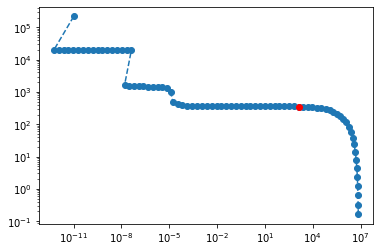

In [14]:
idx=55
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

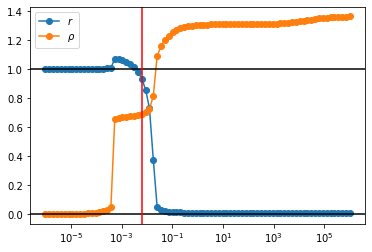

In [15]:
idx=25
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$r$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\rho$')
for q in p0:
    plt.axhline(q, color='k')
plt.axvline(prange[idx], color='r')
plt.xscale('log')
plt.yscale('linear')
plt.legend()

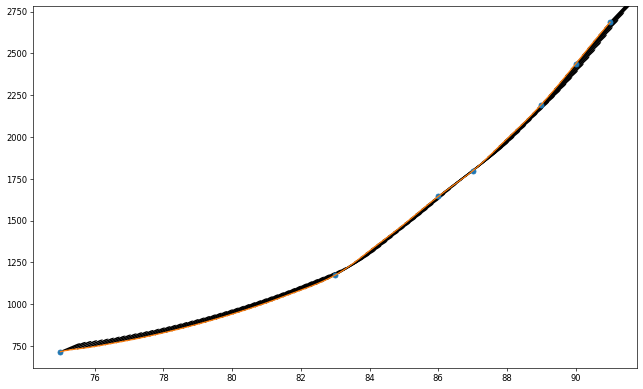

In [16]:
idx=25
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
ax.plot(times, cumdata, 'o', label='Data')
ax.plot(model.observation_times, getx(sols[idx]['x']), label='C')
xx = getx(sols[idx]['x']).toarray().flatten()
ax.quiver(model.observation_times, xx, [1]*len(model.observation_times), 
          np.array([rcp(0, [xxi], [float(q) for q in getp(sols[idx]['x'])]) for xxi in xx]).flatten(), 
          angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025)

In [17]:
p1 = getp(sols[idx]['x'])
p1

(DM(0.933385), DM(0.689184))

In [ ]:
A=-67
teas = np.linspace(times[0], times[-1], 20)
plt.plot(times, cumdata, teas, (p1[0]*(1-p1[1])*teas + A)**(1/(1-p1[1]))